In [21]:
# Install and setup dependencies
# First cell is necessary to disable the cache in JAX-COSMO
import os
os.environ["JC_CACHE"] = "off"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Uncomment if jax_cosmo needs to be installed/updated
# !pip install --quiet git+https://github.com/ASKabalan/jax_cosmo &> /dev/null

# Ray Tracing with JaxPM

This notebook demonstrates how to perform ray tracing simulations using `JaxPM` to generate weak lensing convergence maps. It covers the full pipeline from setting up initial conditions, running an
N-body simulation, extracting density planes, and finally computing and visualizing the convergence maps.

**Key Concepts:**
-   **Cosmology Setup:** Defining the cosmological model using `jax_cosmo`.
-   **Initial Conditions:** Generating initial density fields and particle displacements using Linear Perturbation Theory (LPT).
-   **N-body Simulation:** Evolving the particle distribution over time using a symplectic ODE solver.
-   **Density Plane Extraction:** Slicing the 3D particle distribution into 2D density planes at various redshifts.
-   **Weak Lensing Convergence:** Computing the convergence ($\kappa$) maps from the density planes using the Born approximation.
-   **Visualization:** Plotting density planes and convergence maps.

In [22]:
from functools import partial
from typing import Any, NamedTuple

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_cosmo.constants as constants
from diffrax import ODETerm, RecursiveCheckpointAdjoint, SaveAt, diffeqsolve, SemiImplicitEuler, ConstantStepSize
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.distributed import fft3d, ifft3d, normal_field, uniform_particles
from jaxpm.kernels import fftk
from jaxpm.painting import cic_paint_2d, cic_paint_dx
from jaxpm.pm import growth_factor, growth_rate, pm_forces, linear_field, lpt, make_diffrax_ode
from jaxpm.growth import E
from jaxpm.utils import gaussian_smoothing
from jaxpm.ode import symplectic_ode
from jaxpm.lensing import density_plane_fn, convergence_Born
import matplotlib.pyplot as plt
from scipy.stats import norm

print("All imports successful!")

All imports successful!


In [23]:
jax.config.update("jax_enable_x64", False)

# Flat Sky Projection

   ## 1. Setup and Cosmology
   
   First, we import necessary libraries and define our cosmological model. We use `jax_cosmo` for cosmological calculations and `diffrax` for solving the N-body ODE.

In [24]:
Planck18 = partial(
    jc.Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

fiducial_cosmo = Planck18()

## 2. Simulation Parameters
  
Here, we define the key parameters for our N-body simulation and ray tracing. These include the mesh shape, box size, and properties related to the density planes and lensing fields.


In [25]:
# Simulation Parameters
# Reduced parameters for testing - increase for production runs
mesh_shape = [256, 256, 256]  # Use [256, 256, 256] for full resolution
box_size = [800.0, 800.0, 800.0]
density_plane_width = 50.0
density_plane_npix = 256  # Match mesh_shape[0] for simplicity
density_plane_smoothing = 0.1  # Set to 0 to disable smoothing
field_size = 9.6  # degrees
field_npix = 256  # Match mesh_shape[0] for simplicity
min_redshift = 0.0

print(f"Mesh shape: {mesh_shape}")
print(f"Box size: {box_size} Mpc/h")
print(f"Density plane resolution: {density_plane_npix}x{density_plane_npix}")
print(f"Field size: {field_size} degrees with {field_npix}x{field_npix} pixels")

Mesh shape: [256, 256, 256]
Box size: [800.0, 800.0, 800.0] Mpc/h
Density plane resolution: 256x256
Field size: 9.6 degrees with 256x256 pixels


## Redshift Distribution of Sources

We define and visualize the redshift distribution of source galaxies. This distribution is crucial for weighting the contribution of different density planes to the final convergence map.

/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


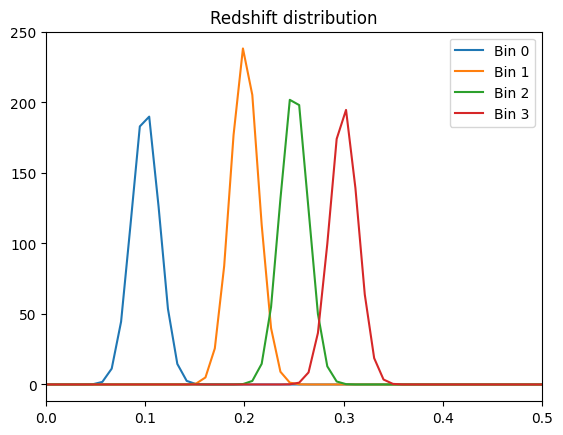

In [26]:
from scipy.stats import norm

max_comoving_distance = box_size[2]  # in Mpc/h
max_redshift = (1 / jc.background.a_of_chi(fiducial_cosmo, max_comoving_distance / fiducial_cosmo.h) - 1).squeeze()
z = jnp.linspace(0, max_redshift, 1000)

nz_shear = [
    jc.redshift.kde_nz(
        z, norm.pdf(z, loc=z_center, scale=0.01), bw=0.01, zmax=max_redshift, gals_per_arcmin2=g
    )
    for z_center, g in zip([0.1, 0.2, 0.25, 0.3], [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)


# Plotting the redshift distribution
z = jnp.linspace(0, 1.2, 128)

for i in range(nbins):
    plt.plot(
        z,
        nz_shear[i](z) * nz_shear[i].gals_per_arcmin2,
        color=f"C{i}",
        label=f"Bin {i}",
    )
plt.legend()
plt.xlim(0, 0.5)
plt.title("Redshift distribution")
plt.show()


## 4. Running the N-body Simulation

This section sets up and runs the N-body simulation.
-   We generate initial conditions based on a linear matter power spectrum.
-   Particles are displaced using LPT.
-   The simulation is evolved using a symplectic ODE solver from `diffrax`.
-   During the simulation, density planes are extracted at specific scale factors (redshifts) using the `density_plane_fn`.



In [27]:
t0 = 0.1  # Initial scale factor
t1 = 1.0  # Final scale factor
dt0 = 0.05  # Initial time step

@jax.jit
def run_simulation(cosmo):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles=None,a=0.1,order=1)
    
    # Evolve the simulation forward
    drift , kick = symplectic_ode(mesh_shape, paint_absolute_pos=False)
    ode_fn = ODETerm(kick), ODETerm(drift)
    solver = SemiImplicitEuler()


    a_init = t0
    n_lens = int(box_size[-1] // density_plane_width)
    r = jnp.linspace(0.0, box_size[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)
    saveat = SaveAt(ts=a_center[::-1], fn=density_plane_fn(mesh_shape, box_size, density_plane_width, density_plane_npix, None))

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=t0,
                      t1=t1,
                      dt0=dt0,
                      y0=(p , dx),
                      args=cosmo,
                      saveat=saveat,
                      stepsize_controller=stepsize_controller)

    density_planes = res.ys
    return initial_conditions ,  dx , density_planes , res.stats

initial_conditions , lpt_displacements , density_planes , solver_stats = run_simulation(fiducial_cosmo)

## 5. Visualizing Density Planes

After running the simulation, we can visualize the extracted 2D density planes. Each plane represents the matter distribution at a specific redshift slice.


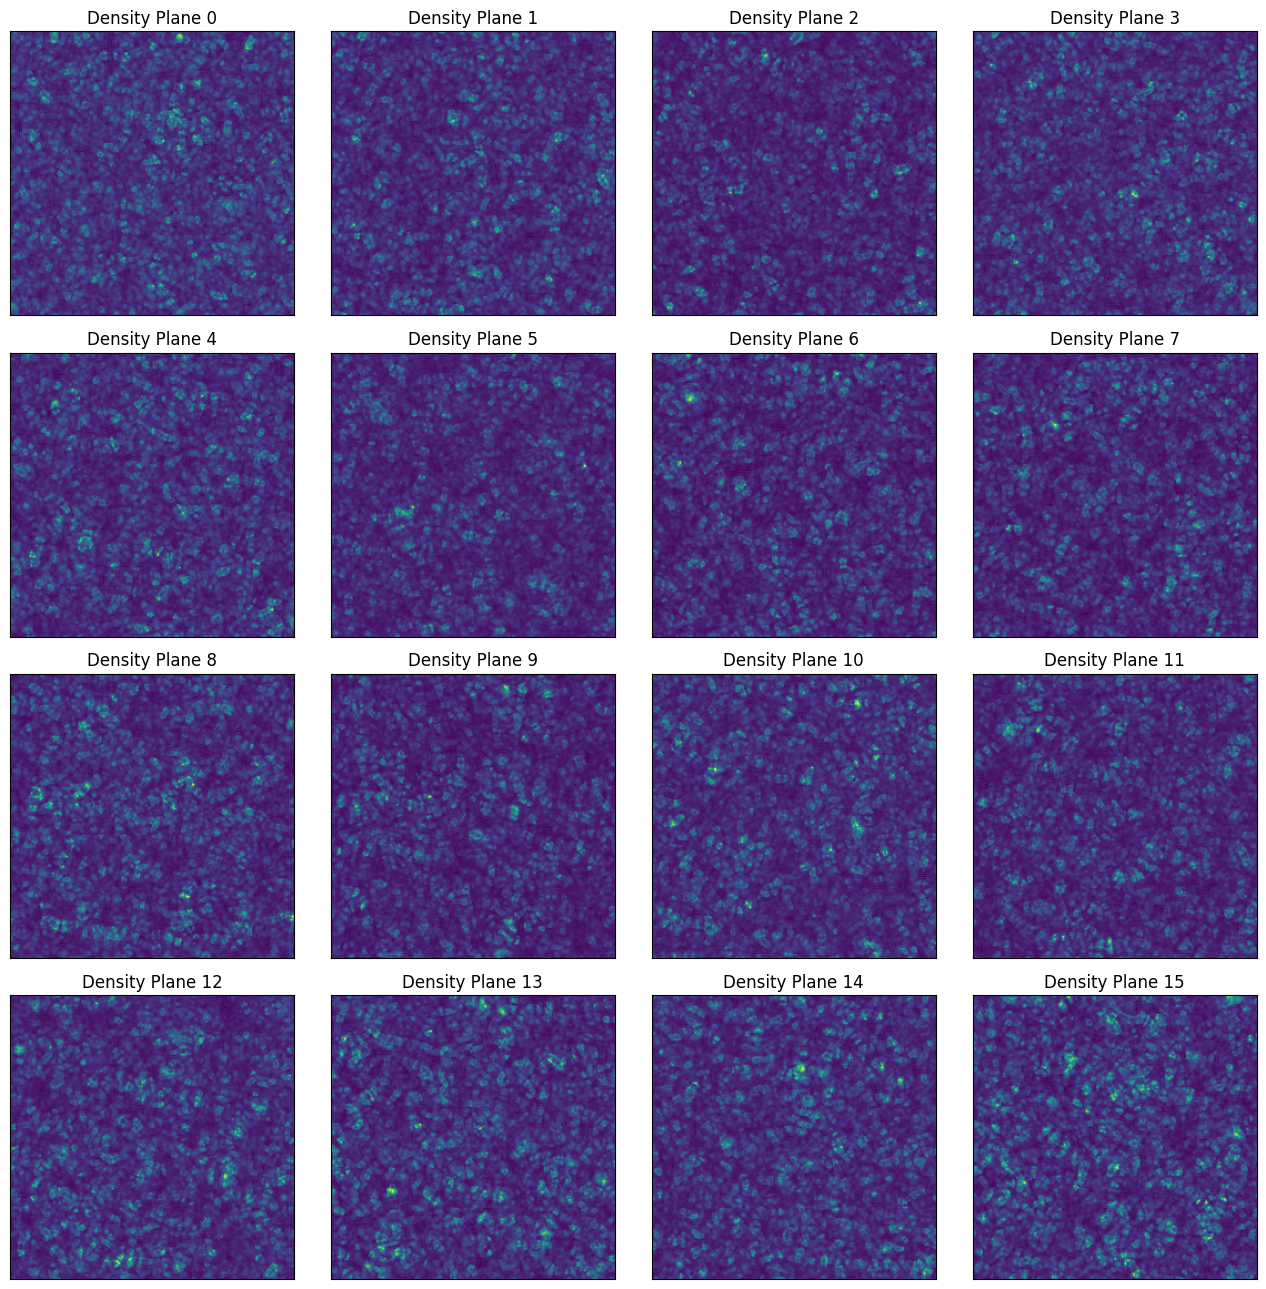

In [28]:
fig = plt.figure(figsize=(13, 13))

for i , density_plane in enumerate(density_planes):
    plt.subplot(4, 4, i + 1)
    plt.imshow(density_plane, origin="lower", cmap="viridis", extent=[0, box_size[0], 0, box_size[1]])
    plt.title(f"Density Plane {i}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

 ## 6. Computing Weak Lensing Convergence Maps
   
  Finally, we compute the weak lensing convergence maps.
  -   The `compute_convergence` function takes the extracted density planes and integrates them along the line of sight, weighted by the source redshift distribution, to produce convergence maps.
  -   The Born approximation is used for this calculation.
  -   The resulting maps are then visualized.



In [29]:
def compute_convergence(density_planes, cosmo, field_size, field_npix, min_redshift=0.0, max_redshift=2.0):
    """
    Compute weak lensing convergence maps from density planes.
    
    Parameters:
    -----------
    density_planes : array
        2D density planes extracted from the simulation
    cosmo : Cosmology
        Cosmological model
    field_size : float
        Size of the lensing field in degrees
    field_npix : int
        Number of pixels for the output convergence map
    min_redshift, max_redshift : float
        Redshift integration bounds
    
    Returns:
    --------
    convergence_maps : list
        List of convergence maps for each redshift bin
    """
    dx = box_size[0] / density_plane_npix
    dz = density_plane_width

    n_lens = int(box_size[-1] // density_plane_width)
    r = jnp.linspace(0.0, box_size[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)

    # Apply smoothing to density planes if needed
    if density_plane_smoothing > 0:
        lightcone = jax.vmap(lambda x: gaussian_smoothing(x, density_plane_smoothing / dx))(
            density_planes
        )
    else:
        lightcone = density_planes

    lightcone = lightcone[::-1]
    
    # Define coordinate grid for lensing map
    xgrid, ygrid = jnp.meshgrid(
        jnp.linspace(0, field_size, mesh_shape[0], endpoint=False),
        jnp.linspace(0, field_size, mesh_shape[1], endpoint=False),
    )
    coords = jnp.array((jnp.stack([xgrid, ygrid], axis=0)) * (jnp.pi / 180))  # deg->rad

    # Compute convergence maps for each redshift bin
    convergence_maps = [
        simps(
            lambda z: nz(z).reshape([-1, 1, 1])
            * convergence_Born(cosmo, lightcone, r_center, a_center, z, d_r=density_plane_width, dx=dx, coords=coords),
            min_redshift,
            max_redshift,
            N=32,
        )
        for nz in nz_shear
    ]

    # Reshape maps to desired resolution
    convergence_maps = [
        kmap.reshape([
            field_npix,
            mesh_shape[0] // field_npix,
            field_npix,
            mesh_shape[1] // field_npix,
        ])
        .mean(axis=1)
        .mean(axis=-1)
        for kmap in convergence_maps
    ]
    return convergence_maps


print("Computing convergence maps...")
kappas = compute_convergence(density_planes, fiducial_cosmo, field_size, field_npix)
print(f"Generated {len(kappas)} convergence maps")

Computing convergence maps...
Generated 4 convergence maps


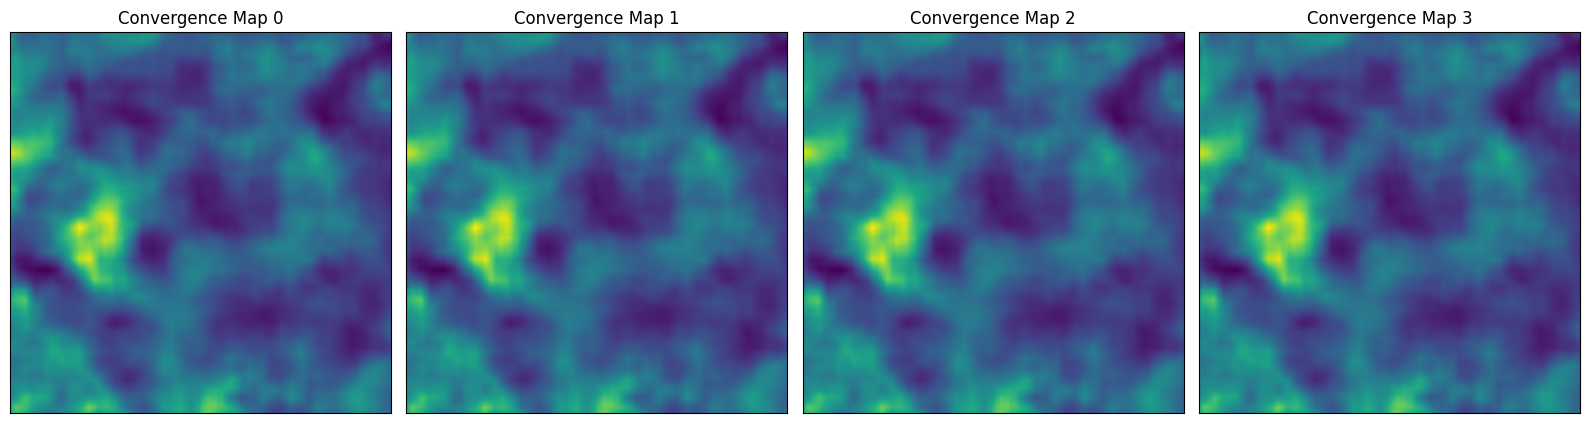

In [30]:
fig = plt.figure(figsize=(16, 16))
for i, kappa in enumerate(kappas):
    plt.subplot(1, 4, i + 1)
    plt.imshow(kappa, origin="lower", cmap="viridis", extent=[0, field_size, 0, field_size])
    plt.title(f"Convergence Map {i}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## 7. Angular Power Spectrum Analysis

Finally, we compute the angular power spectra from the flat-sky convergence maps and compare with theoretical predictions.

In [31]:
from lenstools import ConvergenceMap
import astropy.units as u
import numpy as np

def compute_theory_power_spectrum(cosmo, ell, z_source):
    """
    Compute theoretical angular power spectrum for weak lensing.
    """
    # Create weak lensing tracer
    tracer = jc.probes.WeakLensing(
        [jc.redshift.delta_nz(z_source)],
        sigma_e=0.0  # No shape noise
    )
    
    # Compute theoretical C_ell
    cl_theory = jc.angular_cl.angular_cl(
        cosmo=cosmo,
        ell=ell,
        probes=[tracer]
    )
    
    return cl_theory[0]  # Extract auto-correlation

# Compute power spectra for all convergence maps using lenstools
print("Computing angular power spectra with lenstools...")

# Define ell range for power spectrum
ell = jnp.linspace(50, 1000, 20)

# Get source redshifts for each bin (approximate peak of n(z))
source_redshifts = [0.1, 0.2, 0.25, 0.3]  # Corresponding to the 4 redshift bins

power_spectra = []
for i, (kappa, z_s) in enumerate(zip(kappas, source_redshifts)):
    print(f"Processing convergence map {i} (z_source = {z_s})")
    
    # Create ConvergenceMap object using lenstools
    conv_map = ConvergenceMap(
        np.array(kappa),
        angle=field_size * u.deg,  # Convert field size to astropy units
    )
    
    # Compute power spectrum using lenstools (this handles flat-sky correctly)
    ells_centers, cl_sim = conv_map.powerSpectrum(ell)
    
    # Compute theoretical power spectrum
    cl_theory = compute_theory_power_spectrum(fiducial_cosmo, ells_centers, z_s)
    
    power_spectra.append({
        'ell': ells_centers,
        'cl_sim': cl_sim,
        'cl_theory': cl_theory,
        'z_source': z_s,
        'bin_index': i
    })

print(f"✓ Computed power spectra for {len(power_spectra)} convergence maps using lenstools")

Computing angular power spectra with lenstools...
Processing convergence map 0 (z_source = 0.1)
Processing convergence map 1 (z_source = 0.2)
Processing convergence map 2 (z_source = 0.25)
Processing convergence map 3 (z_source = 0.3)
✓ Computed power spectra for 4 convergence maps using lenstools


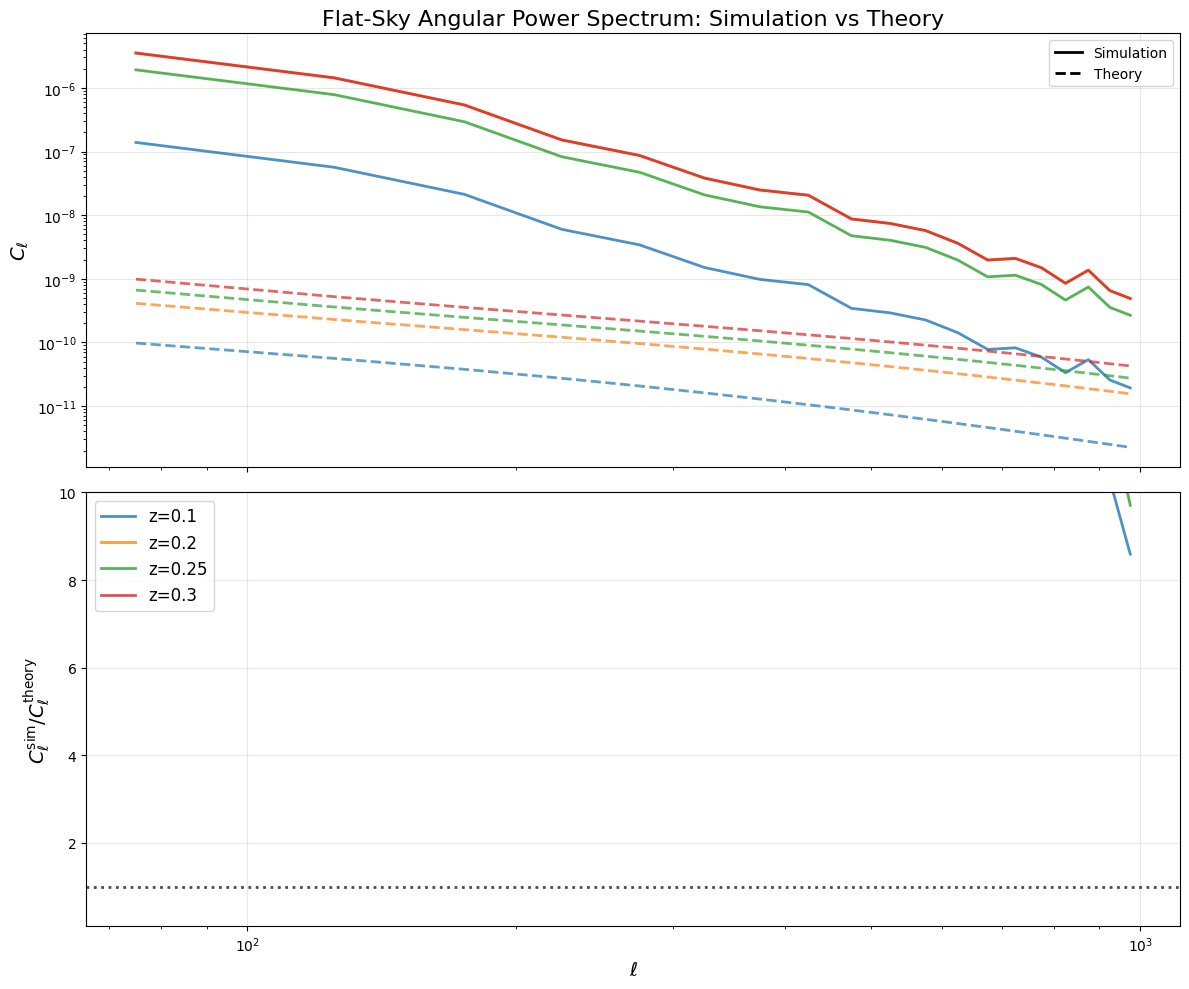


Summary Statistics:
------------------------------------------------------------
Redshift bin z=0.1:
  Mean ratio (20 ≤ ℓ ≤ 200): 995.178
  Std ratio: 350.238
  Agreement: 99517.8% of theory

Redshift bin z=0.2:
  Mean ratio (20 ≤ ℓ ≤ 200): 6064.003
  Std ratio: 2116.693
  Agreement: 606400.3% of theory

Redshift bin z=0.25:
  Mean ratio (20 ≤ ℓ ≤ 200): 2077.375
  Std ratio: 696.719
  Agreement: 207737.5% of theory

Redshift bin z=0.3:
  Mean ratio (20 ≤ ℓ ≤ 200): 2604.811
  Std ratio: 842.631
  Agreement: 260481.1% of theory

✓ Flat-sky angular power spectrum analysis complete!


In [32]:
# Plot comparison between simulation and theory
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Top panel: Power spectra
for i, ps in enumerate(power_spectra):
    color = colors[i]
    
    # Plot simulation
    ax1.loglog(ps['ell'], ps['cl_sim'], color=color, linewidth=2, 
              label=f'Simulation (z={ps["z_source"]})', alpha=0.8)
    
    # Plot theory
    ax1.loglog(ps['ell'], ps['cl_theory'], color=color, linestyle='--', 
              linewidth=2, alpha=0.7)

# Add legend
sim_line = plt.Line2D([0], [0], color='black', linewidth=2, label='Simulation')
theory_line = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Theory')
ax1.legend(handles=[sim_line, theory_line], loc='upper right')

ax1.set_ylabel(r'$C_\ell$', fontsize=14)
ax1.set_title('Flat-Sky Angular Power Spectrum: Simulation vs Theory', fontsize=16)
ax1.grid(True, alpha=0.3)

# Bottom panel: Ratios
for i, ps in enumerate(power_spectra):
    color = colors[i]
    ratio = ps['cl_sim'] / ps['cl_theory']
    
    ax2.semilogx(ps['ell'], ratio, color=color, linewidth=2, 
                label=f'z={ps["z_source"]}', alpha=0.8)

# Add perfect agreement line
ax2.axhline(1, color='black', linestyle=':', alpha=0.7, linewidth=2)

ax2.set_xlabel(r'$\ell$', fontsize=14)
ax2.set_ylabel(r'$C_\ell^{\mathrm{sim}} / C_\ell^{\mathrm{theory}}$', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.1, 10)  # Reasonable range for ratios

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 60)
for ps in power_spectra:
    ratio = ps['cl_sim'] / ps['cl_theory']
    
    # Focus on well-resolved modes
    mask = (ps['ell'] >= 20) & (ps['ell'] <= 200)
    if np.sum(mask) > 0:
        ratio_wellresolved = ratio[mask]
        mean_ratio = np.mean(ratio_wellresolved)
        std_ratio = np.std(ratio_wellresolved)
        
        print(f"Redshift bin z={ps['z_source']}:")
        print(f"  Mean ratio (20 ≤ ℓ ≤ 200): {mean_ratio:.3f}")
        print(f"  Std ratio: {std_ratio:.3f}")
        print(f"  Agreement: {mean_ratio:.1%} of theory")
        print()

print("✓ Flat-sky angular power spectrum analysis complete!")